In [2]:
import os
import sys
os.path.expanduser('~')
sys.path.append(os.path.join(os.path.expanduser('~'),'software','src','nixSuite','wrapper'))
import nixWrapper
nixWrapper.loadLibrary('labkeyInterface')
import labkeyInterface


In [3]:
net=labkeyInterface.labkeyInterface()
fconfig=os.path.join(os.path.expanduser('~'),'.labkey','network.json')
net.init(fconfig)
net.getCSRF()

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 43ecc396291ad292473c4fc867b7b2a9


'43ecc396291ad292473c4fc867b7b2a9'

In [4]:
import labkeyFileBrowser
import downloadPatient
fb=labkeyFileBrowser.labkeyFileBrowser(net)
project='dinamic_spect/Patients'
locDir=os.path.join(os.path.expanduser('~'),'temp','dynamicSPECT')

In [5]:
#download files
import labkeyDatabaseBrowser
db=labkeyDatabaseBrowser.labkeyDB(net)
ds=db.selectRows(project,'study','Imaging',[])
patients=[row['aliasID'] for row in ds['rows']]
patients1=['7TMOBR']
for p in patients1:
    pass

    #patientId='7TMMIR'
    #files=downloadPatient.readPatient(fb,locDir,project,p)

In [6]:
import SimpleITK
import matplotlib.pyplot
import numpy

In [7]:
def getPatientNIM(id):
    f=os.path.join(locDir,id,id+'Volume19.nrrd')
    im=SimpleITK.ReadImage(f)
    nim=SimpleITK.GetArrayFromImage(im)
    return nim
    

2SBMIR: [28]:160521.0 0.3870876729488373


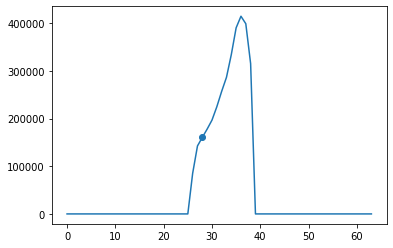

In [888]:
patients1=[patients[4]]
for p in patients1:
    if p.find('8')==0:
        continue
    f=os.path.join(locDir,p,p+'Volume19.nrrd')
    im=SimpleITK.ReadImage(f)
    nim=SimpleITK.GetArrayFromImage(im)
    pz=list(numpy.sum(numpy.sum(nim,0),1))
    pz1=[pz[i-1]+pz[i+1]-2*pz[i] for i in numpy.arange(1,len(pz)-1)]
    imin=pz1.index(min(pz1))
    imax=pz.index(max(pz))
    imin-=9
    print('{}: [{}]:{} {}'.format(p,imin,pz[imin],pz[imin]/pz[imax]))
    matplotlib.pyplot.plot(pz)
    matplotlib.pyplot.scatter(imin,pz[imin])
    
matplotlib.pyplot.show()


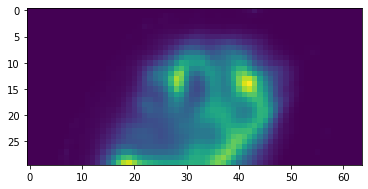

In [257]:
matplotlib.pyplot.imshow(nim[:,31,:])
matplotlib.pyplot.show()

In [11]:
def getSegment(nim,tip,base,w1,w2):
    ctr=base+1/3.*(tip-base)
    kap=base+2/3.*(tip-base)
    n=(tip-base)/numpy.sqrt(numpy.dot(tip-base,tip-base))
    sphCtr=tip-w2*n;
    print(n)
    x,y,z=numpy.meshgrid(numpy.arange(nim.shape[0])+0.5,numpy.arange(nim.shape[1])+0.5,numpy.arange(nim.shape[2])+0.5,indexing='xy')
    #because of xy ordering, columns 2 and 1 are swapped, but that seems to fit well with reshape
    #location coded as (r)
    fr=numpy.array([x,y,z])
    fr1=fr.transpose()
    fr2=fr1.reshape(nim.size,-1)
    print(fr2.shape)
    #require r to lie above the r*n plane
    fw=numpy.dot(fr2,n)
    fw=fw.reshape(x.shape)
    print(fw.shape)
    fwkap=numpy.dot(kap,n)
    fwctr=numpy.dot(ctr,n)
    fwbase=numpy.dot(base,n)
    
    fcSph=numpy.array([sphCtr[0]*numpy.ones(x.shape),sphCtr[1]*numpy.ones(x.shape),sphCtr[2]*numpy.ones(x.shape)])
    fcSph1=fcSph.transpose()
    fcSph2=fcSph1.reshape((nim.size,-1))
    vcSph=numpy.array([numpy.dot(v1-v2,v1-v2) for (v1,v2) in zip(fcSph2,fr2)])
    vcSph2=vcSph.reshape(x.shape)
    
    fc=numpy.array([ctr[0]*numpy.ones(x.shape),ctr[1]*numpy.ones(x.shape),ctr[2]*numpy.ones(x.shape)])
    fc1=fc.transpose()
    fc2=fc1.reshape((nim.size,-1))
    vc=numpy.array([numpy.dot(v1-v2,v1-v2) for (v1,v2) in zip(fc2,fr2)])
    print('vc shape {}'.format(vc.shape))
    vc2=vc.reshape(x.shape)
    vcrho2=numpy.array([numpy.dot(v1-v2,n)*numpy.dot(v1-v2,n) for (v1,v2) in zip(fc2,fr2)])
    vcrho2Flat=vc-vcrho2
    print(len(vcrho2Flat[vcrho2Flat<0]))
    vcrho2=vcrho2.reshape(x.shape)
    vcrho2=vc2-vcrho2

    vcsqrt=numpy.sqrt(vcrho2Flat)
    print(len(vcsqrt[vcsqrt==0]))
    tgphi2=numpy.array([(v1[2]-v2[2]) for (v1,v2) in zip(fr2,fc2)])
    tgphi2[vcsqrt>0]/=vcsqrt[vcsqrt>0]
    tgphi2=tgphi2.reshape(x.shape)
    tgphi1=numpy.array([(v1[1]-v2[1]) for (v1,v2) in zip(fr2,fc2)])
    tgphi1[vcsqrt>0]/=vcsqrt[vcsqrt>0]
    tgphi1=tgphi1.reshape(x.shape)
    print('Shape (tgphi):{}'.format(tgphi1.shape))
    
    cap=9*numpy.ones(x.shape)
    cap[vcSph2<w1*w1]=0
    cap[vcSph2>w2*w2]=0
    cap[fw<fwkap]=0
    
    bar1=numpy.ones(x.shape)
    bar1[vcrho2>w2*w2]=0
    bar1[vcrho2<w1*w1]=0
    bar1[fw<fwctr]=0
    bar1[fw>fwkap]=0
    bar1[tgphi2>numpy.sqrt(2)/2]*=4
    bar1[tgphi2<-numpy.sqrt(2)/2]*=2
    bar1[tgphi1>numpy.sqrt(2)/2]*=3
    bar1[tgphi1<-numpy.sqrt(2)/2]*=1
    bar1[bar1>0]+=4

    bar2=numpy.ones(x.shape)
    bar2[vcrho2>w2*w2]=0
    bar2[vcrho2<w1*w1]=0
    bar2[fw>fwctr]=0
    bar2[fw<fwbase]=0
    bar2[tgphi2>numpy.sqrt(2)/2]*=4
    bar2[tgphi2<-numpy.sqrt(2)/2]*=2
    bar2[tgphi1>numpy.sqrt(2)/2]*=3
    bar2[tgphi1<-numpy.sqrt(2)/2]*=1

    segm=bar1\
        +cap\
        +bar2\
    #transpose back to nim space (equivalent to ij indexing order)
    vc2=numpy.transpose(vc2,axes=[1,0,2])
    segm=numpy.transpose(segm,axes=[1,0,2])
    return segm



In [987]:
pId='5MIMIR'
idFilter={'variable':'aliasID','value':pId,'oper':'eq'}
ds=db.selectRows(project,'study','Imaging',[idFilter])
rows=ds['rows']
outrows=[]
for r in rows:
    p=r['aliasID']
    if p.find('8')==0:
        continue
    f=os.path.join(locDir,p,p+'Volume19.nrrd')
    im=SimpleITK.ReadImage(f)
    nim=SimpleITK.GetArrayFromImage(im)
    tip=numpy.array([float(r[x]) for x in ['tipX','tipY','tipZ']])
    base=numpy.array([float(r[x]) for x in ['baseX','baseY','baseZ']])
    segm=getSegment(nim,tip,base,float(r['w1']),float(r['w2']))
    #adjust file name
    outDir=os.path.join(locDir,p)
    if not os.path.isdir(outDir):
        os.makedirs(outDir)
    segmImage=SimpleITK.GetImageFromArray(segm)
    segmImage.SetOrigin(im.GetOrigin())
    segmImage.SetDirection(im.GetDirection())
    segmImage.SetSpacing(im.GetSpacing())
    fname=p+'_Segm.nrrd'
    SimpleITK.WriteImage(segmImage,os.path.join(locDir,p,fname))
    r['segmentation']=fname
    r['CT']=p+'CT.nrrd'
    outrows.append(r)
    remoteSegmentation=fb.buildPathURL(project,[p])
    remoteSegmentation+='/'+fname
    fb.writeFileToFile(os.path.join(locDir,p,fname),remoteSegmentation)
db.modifyRows('update',project,'study','Imaging',outrows)

[-1.  0.  0.]
(114688, 3)
(64, 28, 64)
vc shape (114688,)
0
0
Shape (tgphi):(64, 28, 64)


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 7cefbfa156cf7df98b848d539c3da76e
User: andrej studen CSRF: 5d36f73137830665383bdf7cfd5f49b1


b'{\n  "rowsAffected" : 1,\n  "queryName" : "Imaging",\n  "schemaName" : "study",\n  "containerPath" : "/dinamic_spect/Patients",\n  "rows" : [ {\n    "date" : null,\n    "dsrowid" : 112,\n    "CreatedBy" : 1090,\n    "sliceView" : "5MIMIR_sliceView.png",\n    "tipY" : 32.0,\n    "tipZ" : 32.5,\n    "ctData" : "2",\n    "QCState" : null,\n    "tipX" : 6.0,\n    "SequenceNum" : 1.0000,\n    "Created" : "2019/07/11 12:02:39",\n    "lsid" : "urn:lsid:ijs.si:Study.Data-113:5001.5MI.1.0000",\n    "CT" : "5MIMIRCT.nrrd",\n    "baseX" : 18.0,\n    "aliasID" : "5MIMIR",\n    "sourcelsid" : null,\n    "nmCorrData" : "9",\n    "PatientId" : "5MI",\n    "segmentation" : "5MIMIR_Segm.nrrd",\n    "baseY" : 32.0,\n    "w1" : 2.0,\n    "nmMaster" : "4",\n    "w2" : 6.0,\n    "baseZ" : 32.5\n  } ],\n  "command" : "update"\n}'

In [7]:
#test a segmentation
pId='5MIMIR'
nim=getPatientNIM(pId)
idFilter={'variable':'aliasID','value':pId,'oper':'eq'}
ds=db.selectRows(project,'study','Imaging',[idFilter])
r=[row for row in ds['rows'] if row['aliasID']==pId][0]
tip=numpy.array([float(r[x]) for x in ['tipX','tipY','tipZ']])
base=numpy.array([float(r[x]) for x in ['baseX','baseY','baseZ']])
segm=getSegment(nim,tip,base,float(r['w1']),float(r['w2']))
slc=32
matplotlib.pyplot.imshow(segm[:,slc,:])
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(segm[:,slc,:])
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(nim[:,slc,:])
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(nim[:,slc,:])
matplotlib.pyplot.imshow(segm[:,slc,:],alpha=0.2)
matplotlib.pyplot.show()

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


NameError: name 'getSegment' is not defined

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


16
User: andrej studen CSRF: b2c5deaab50bbf312e803a4cb3ef654e
User: andrej studen CSRF: 257a1acd17787f893ba19e2cf7e4dece
User: andrej studen CSRF: cfa94419791e6d319f39db3b13dce0e8
User: andrej studen CSRF: 9d1d2f1e76553c26eebf4a9a7e899894
User: andrej studen CSRF: e7120ad92526021212ce0b35a7d8cc5d
User: andrej studen CSRF: ba551108b45a9b4265a90ea84293ddb8
User: andrej studen CSRF: ad3ce0403b63f901b140bf6b0e0170bd
User: andrej studen CSRF: 1aaa66797a94a9d2e367ecb246c380db
User: andrej studen CSRF: 8f9253891755ab14c876b8410f359da7
User: andrej studen CSRF: 5507dd1a79c30bb4d0c658cffdac8b4a
User: andrej studen CSRF: d9a4fa48be3393f3e6af67b74c0cfe1a
User: andrej studen CSRF: 94c79b240b55d4d4241de6c63af139e5
User: andrej studen CSRF: 631565d37ef0465a614d56c1566fa652
User: andrej studen CSRF: 364c4c95011879d23cba730802820615
User: andrej studen CSRF: be4a3a5941458ae25a28213cb92cdf53
User: andrej studen CSRF: c564a5e90bb291a3f4559426b636eaa0


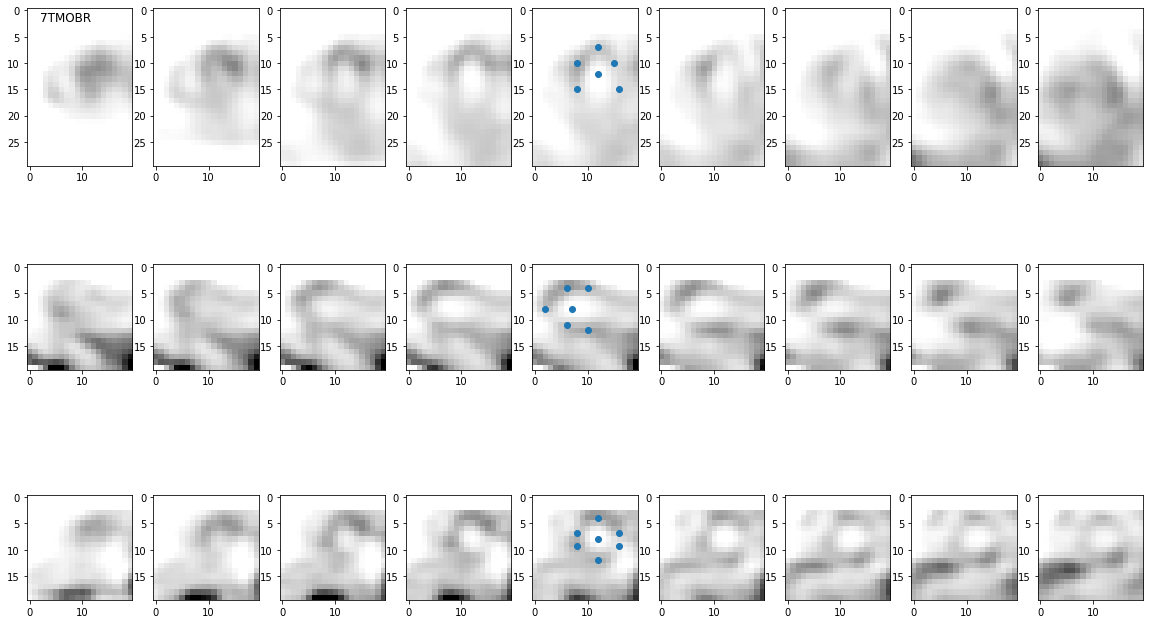

In [151]:
#manipulate segmentations
pId='7TMOBR'
save=True
nim=getPatientNIM(pId)
idFilter={'variable':'aliasID','value':pId,'oper':'eq'}
ds=db.selectRows(project,'study','Imaging',[idFilter])
r=[row for row in ds['rows'] if row['aliasID']==pId][0]
tip=numpy.array([float(r[x]) for x in ['tipX','tipY','tipZ']])
base=numpy.array([float(r[x]) for x in ['baseX','baseY','baseZ']])
#segm=getSegment(nim,tip,base,float(r['w1']),float(r['w2']))

fp=[]
for i in numpy.arange(16):
    sNum=r['SequenceNum']+0.0100*i
    seqFilter={'variable':'SequenceNum','value':'{:.2f}'.format(sNum),'oper':'eq'}
    ds=db.selectRows(project,'study','Segmentation',[idFilter,seqFilter])
    
    if len(ds['rows'])==0:
        print('Not found for s={}'.format(sNum))
        sx=12
        sy=28
        sz=32
        rz=4
        oz=0

        slc=[sx,sy,sz]
        p1=[sx,sy,sz]

        #tip
        p2=[7,sy,32]
        p3=[10,sy,sz-rz]
        p5=[15,sy,sz-rz]
        p4=[10,sy,sz+rz-1]
        p6=[15,sy,sz+rz]
        
        p7=[11,sy-rz,sz]
        p8=[11,sy+rz-1,sz]
        p9=[15,sy-rz,sz]
        p10=[15,sy+rz,sz]

        p11=[sx,sy+rz+oz,sz]
        p12=[sx,sy+0.3*rz+oz,sz-rz]
        p13=[sx,sy-0.3*rz+oz,sz-rz]
        p14=[sx,sy-rz+oz,sz]
        p15=[sx,sy-0.3*rz+oz,sz+rz]
        p16=[sx,sy+0.3*rz+oz,sz+rz]
        break
    else:
        frow=ds['rows'][0]
        fp.append([float(x) for x in [frow['x'],frow['y'],frow['z']]])
        fpp=fp[-1]
        if i==0:
            sx=int(fpp[0])
            sy=int(fpp[1])
            sz=int(fpp[2])

if len(fp)>0:
    print(len(fp))
    p1=fp[0]
    p2=fp[1]
    p3=fp[2]
    p4=fp[3]
    p5=fp[4]
    p6=fp[5]
    p7=fp[6]
    p8=fp[7]
    p9=fp[8]
    p10=fp[9]
    p11=fp[10]
    p12=fp[11]
    p13=fp[12]
    p14=fp[13]
    p15=fp[14]
    p16=fp[15]

oz=0

#sy+=2
#sx+=1
#sz+=2
#rz=4

slc=[sx,sy,sz]
p1=[sx,sy,sz]

p11=[sx,sy+rz+oz,sz]
p12=[sx,sy+0.3*rz+oz,sz-rz]
p13=[sx,sy-0.3*rz+oz,sz-rz]
p14=[sx,sy-rz+oz,sz]
p15=[sx,sy-0.3*rz+oz,sz+rz]
p16=[sx,sy+0.3*rz+oz,sz+rz]  
    
#p8[1]-=1
#p10[1]-=2
#p8[0]+=1
    
cut0=20
w0=20
cut1=20
w1=20
cut2=5
w2=20
vmax=1000
vmin=100
fig,ax=matplotlib.pyplot.subplots(3,9,figsize=(20,12))
for i in numpy.arange(0,9):
    ax[0,i].imshow(nim[:,slc[1]-4+i,cut0:cut0+w0],cmap='gray_r',vmax=vmax,vmin=vmin)
    ax[1,i].imshow(nim[cut2:cut2+w2,cut0:cut0+w0,slc[2]-4+i].T,cmap='gray_r',vmax=vmax,vmin=vmin)
    ax[2,i].imshow(nim[slc[0]-4+i,cut1:cut1+w1,cut1:cut1+w1],cmap='gray_r',vmax=vmax,vmin=vmin)
    if i==4:
        pt=[p1,p2,p3,p4,p5,p6]
        ax[0,i].scatter([x[2]-cut0 for x in pt],[x[0] for x in pt])
        pt=[p1,p2,p7,p8,p9,p10]
        ax[1,i].scatter([x[0]-cut2 for x in pt],[x[1]-cut0 for x in pt])
        pt=[p1,p11,p12,p13,p14,p15,p16]
        ax[2,i].scatter([x[2]-cut1 for x in pt],[x[1]-cut1 for x in pt])
        
    if i==0:
        ax[0,i].text(2,2,pId,fontsize='large')
        
if save:
    of=os.path.join(locDir,pId,'{}_segments.png'.format(pId))
    matplotlib.pyplot.savefig(of)
    
    ds=db.selectRows(project,'study','Segmentation',[idFilter])
    pts=[p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16]
    for i in numpy.arange(len(pts)):
        seqFilter={'variable':'SequenceNum','value':str(r['SequenceNum']+0.01*i),'oper':'eq'}
        ds=db.selectRows(project,'study','Segmentation',[idFilter,seqFilter])
        if len(ds['rows'])>0:
            qrow=ds['rows'][0]
            mode='update'
        else:
            qrow={}
            qrow['PatientId']=r['PatientId']
            qrow['SequenceNum']=0.01*i+r['SequenceNum']
            qrow['aliasID']=pId
            mode='insert'
        qrow['regionId']=int(i)
        qrow['x']=pts[i][0]
        qrow['y']=pts[i][1]
        qrow['z']=pts[i][2]
        db.modifyRows(mode,project,'study','Segmentation',[qrow])
    
            
matplotlib.pyplot.show()

    
    

In [307]:
n=numpy.zeros((3,3))

In [309]:
n[1,1]=1

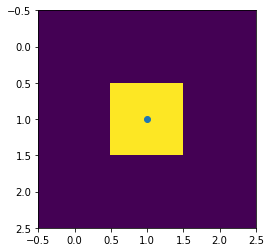

In [314]:
matplotlib.pyplot.imshow(n)
matplotlib.pyplot.scatter([1],[1])